In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from constants import DATA_CLASSES
from sklearn.utils.class_weight import compute_class_weight

In [2]:
NUM_CLASSES = 43
IMAGE_SIZE = (64, 64)

In [3]:
# Load the dataset
data = tf.keras.preprocessing.image_dataset_from_directory("../data/recognition/train", batch_size=8, image_size=IMAGE_SIZE, color_mode="rgb", class_names= [str(k) for k in range(NUM_CLASSES)], shuffle=True)#, crop_to_aspect_ratio=True)
data = data.map(lambda x, y: (x / 255, y))

Found 39209 files belonging to 43 classes.


In [4]:
# Count sample distribution by class
labels = []
for x, y in data:
  # Not one hot encoded
  labels.append(y.numpy())

labels = np.concatenate(labels, axis = 0)
labels = sorted(labels)

sorted_labels = {}
for l in labels:
  if str(l) in sorted_labels.keys():
    sorted_labels[str(l)] += 1 
  else:
    sorted_labels[str(l)] = 1

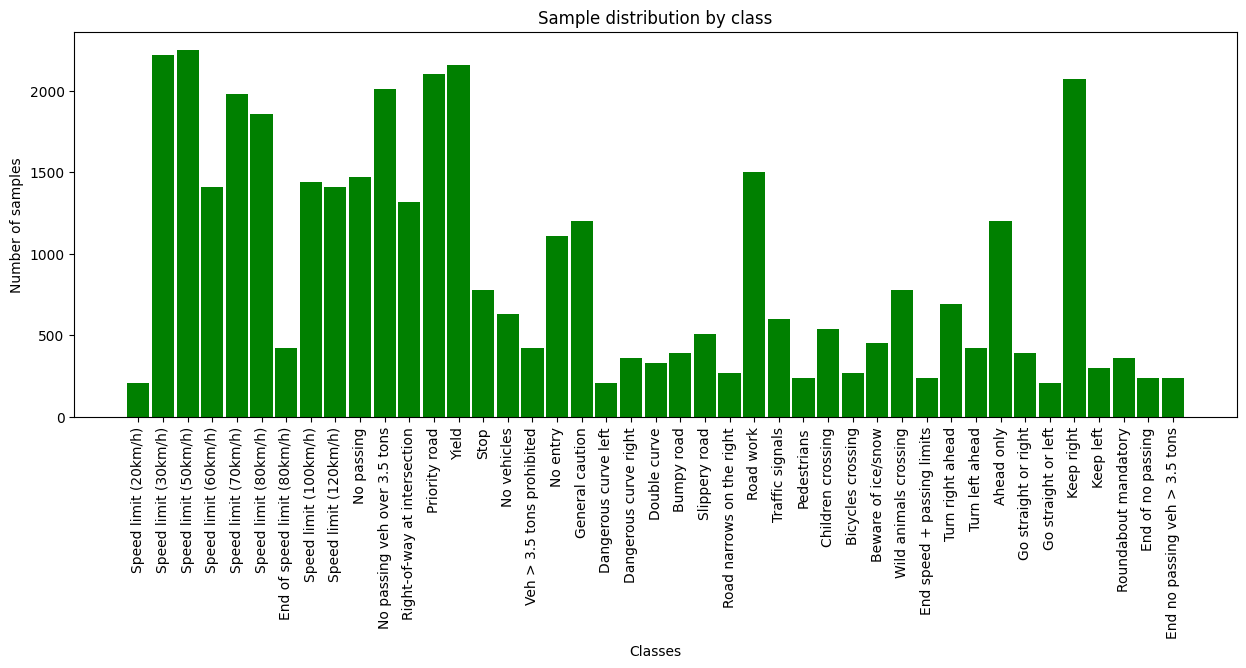

In [5]:
# Plot sample distribution by class
fig = plt.figure(figsize = (15, 5))
 
plt.bar(DATA_CLASSES.values(), sorted_labels.values(), color ='green', width = 0.9)

plt.xticks(rotation='vertical')
plt.xlabel("Classes")
plt.ylabel("Number of samples")
plt.title("Sample distribution by class")
plt.show()

In [6]:
# Calculate class weights
class_weights = {}

for idx, count in sorted_labels.items():
    weight = (1 / count) * (len(labels) / 2.0)
    class_weights[int(idx)] = weight

In [7]:
# Split batches into training and validation sets
batch_count = len(data)
train_size = int(batch_count * 0.8)
val_size = int(batch_count * 0.2)

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)

In [8]:
# Build the model
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="sigmoid"))

In [9]:
# Print the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 16)         0

In [10]:
model.compile("adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [11]:
# Train the model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
checkpoint_file_path = os.path.join('..', 'models', 'recognition', 'checkpoints', 'trafficsignrecognizer_bestcheckpoint07.h5')
checkpointer = ModelCheckpoint(filepath=checkpoint_file_path, verbose=1, save_best_only=True)

hist = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[checkpointer, monitor], class_weight=class_weights)

model.load_weights(checkpoint_file_path)

Epoch 1/100
3918/3921 [============================>.] - ETA: 0s - loss: 25.3696 - accuracy: 0.6713
Epoch 1: val_loss improved from inf to 0.54606, saving model to ..\models\recognition\checkpoints\trafficsignrecognizer_bestcheckpoint07.h5
3921/3921 [==============================] - 64s 16ms/step - loss: 25.3626 - accuracy: 0.6714 - val_loss: 0.5461 - val_accuracy: 0.8503
Epoch 2/100
3921/3921 [==============================] - ETA: 0s - loss: 8.0200 - accuracy: 0.8783
Epoch 2: val_loss improved from 0.54606 to 0.41982, saving model to ..\models\recognition\checkpoints\trafficsignrecognizer_bestcheckpoint07.h5
3921/3921 [==============================] - 67s 17ms/step - loss: 8.0200 - accuracy: 0.8783 - val_loss: 0.4198 - val_accuracy: 0.8841
Epoch 3/100
3920/3921 [============================>.] - ETA: 0s - loss: 4.7034 - accuracy: 0.9211
Epoch 3: val_loss improved from 0.41982 to 0.31026, saving model to ..\models\recognition\checkpoints\trafficsignrecognizer_bestcheckpoint07.h5
392

In [12]:
# Save the model
model.save(os.path.join('..', 'models', 'recognition', 'trafficsignrecognizer07.h5'))

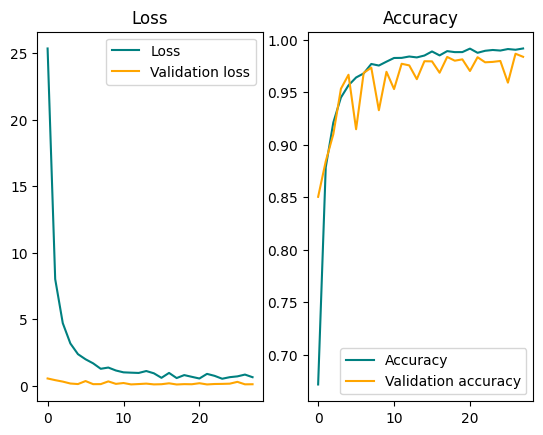

In [13]:
# Plot model performance
plt.subplot(1, 2, 1)

plt.plot(hist.history['loss'], color='teal', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()